# Step 1: Install Required Libraries

In [1]:
!pip install streamlit
!pip install --upgrade nltk
!pip install contractions
!pip install wordcloud
!pip install emoji

# Step 2: Import Libraries

In [2]:
import re
import emoji
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import contractions
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
import pickle

In [3]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Step 3: Read the Dataset

In [5]:

df = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_sentiment.csv', header=None, index_col=0)


# Step 4: Data Cleaning and Preprocessing

In [6]:

df = df[[2, 3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']

In [7]:
# Drop duplicates and missing values
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)


In [8]:
# Text preprocessing
df['text'] = df['text'].str.lower()
df['text'] = df['text'].replace(r'http\S+|www\S+|https\S+', '', regex=True)  # Remove URLs
df['text'] = df['text'].replace(r'@\w+|#\w+', '', regex=True)  # Remove mentions and hashtags
df['text'] = df['text'].replace(r'[^A-Za-z0-9\s]', '', regex=True)  # Remove special characters
df['text'] = df['text'].replace(r'\d+', '', regex=True)  # Remove numbers


In [9]:
# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

df['text'] = df['text'].apply(expand_contractions)

In [10]:

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [11]:
# Lemmatization
lemmatizer = WordNetLemmatizer()
df['text'] = df['text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))


In [12]:
# Handle emojis
df['text'] = df['text'].apply(lambda x: emoji.demojize(x))


In [13]:
# Remove repeated characters
df['text'] = df['text'].apply(lambda x: re.sub(r'(.)\1+', r'\1\1', x))


In [14]:
# Filter out empty tweets
df['tweet_length'] = df['text'].apply(len)
df = df[df['tweet_length'] > 0]


# Step 5: Tokenization

In [15]:
!pip install nltk
import nltk

nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\minag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [16]:
df['text'] = df['text'].apply(word_tokenize)  # Tokenizing the text


# Step 6: Save Cleaned Data

In [17]:
df.to_csv('clean_data.csv', index=False)

# Step 7: Model Training

In [18]:
from sklearn.model_selection import GridSearchCV

In [19]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(df['text'].apply(lambda x: ' '.join(x)), df['sentiment'], test_size=0.2, random_state=42)

# Define the pipeline
clf = Pipeline([
    ('tfid', TfidfVectorizer()),  # Convert text to TF-IDF vectors
    ('lr', LogisticRegression(max_iter=1000))
])

In [20]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'tfid__max_df': [0.8, 0.9, 1.0],
    'tfid__ngram_range': [(1, 1), (1, 2)],
    'lr__C': [0.1, 1, 10],
    'lr__penalty': ['l2', 'none']
}

In [21]:
# Set up the GridSearchCV
grid_search = GridSearchCV(clf, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=1)


In [22]:
# Train the model with GridSearchCV
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 36 candidates, totalling 108 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tfid', TfidfVectorizer()),
                                       ('lr',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'lr__C': [0.1, 1, 10], 'lr__penalty': ['l2', 'none'],
                         'tfid__max_df': [0.8, 0.9, 1.0],
                         'tfid__ngram_range': [(1, 1), (1, 2)]},
             scoring='accuracy', verbose=1)

In [23]:

# Print the best parameters and best score
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

Best parameters found:  {'lr__C': 10, 'lr__penalty': 'l2', 'tfid__max_df': 0.8, 'tfid__ngram_range': (1, 2)}
Best accuracy:  0.8878717713998528


# Step 8: Model Evaluation

In [24]:
# Predict the test set results using the best model
y_pred = grid_search.best_estimator_.predict(X_test)


# Print classification report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

  Irrelevant       0.95      0.89      0.92      2566
    Negative       0.93      0.95      0.94      4153
     Neutral       0.93      0.93      0.93      3408
    Positive       0.92      0.93      0.92      3802

    accuracy                           0.93     13929
   macro avg       0.93      0.93      0.93     13929
weighted avg       0.93      0.93      0.93     13929



# Step 9: Confusion Matrix

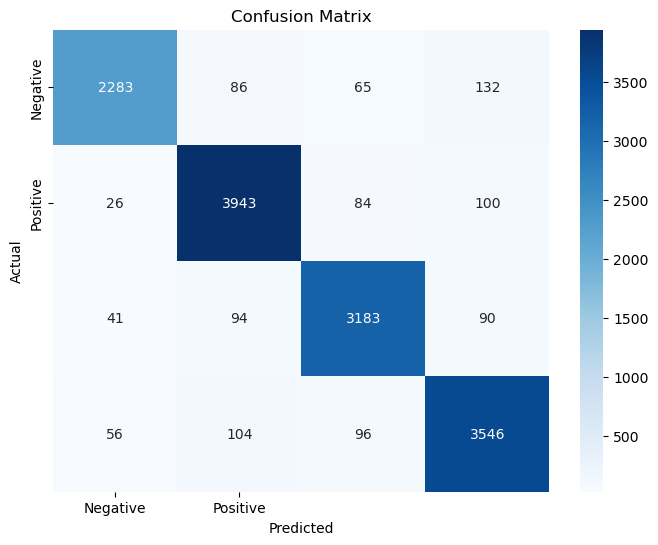

In [25]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Step 10: Save the Model

In [26]:
pickle.dump(grid_search.best_estimator_, open('logistic_twitter_sentiment.pkl', 'wb'))

# Step 11: Test the Model with New Examples

In [27]:
lr = grid_search.best_estimator_

In [28]:
print(lr.predict(['let me not upset you']))
print(lr.predict(['glad to see you']))

['Negative']
['Positive']
